In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Preprocessing

In [2]:
batch_size = 16
num_steps = 1000 # train_steps
eval_steps = 100
lr = 1e-3
context_length = 32
embedding_size = 64 # change this in future and test if it works 
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'cpu'
vocab_size = 39
num_heads = 4
n_blocks = 4  # num_layers or 'N' in transformer block
device

'cpu'

In [3]:
with open('input.txt', 'r', encoding='utf-8' ) as f:
    data = f.read().lower()
len(data)

1115394

In [4]:
chars = sorted(list(set(data)))
chars.remove('3')
chars.append('<UNK>')
print(chars)
len(chars)

['\n', ' ', '!', '$', '&', "'", ',', '-', '.', ':', ';', '?', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '<UNK>']


39

In [5]:
vocab = {}
for t in range(len(chars)):
    vocab[t] = chars[t]

rev_vocab = {v:k for k,v in vocab.items()}
rev_vocab

{'\n': 0,
 ' ': 1,
 '!': 2,
 '$': 3,
 '&': 4,
 "'": 5,
 ',': 6,
 '-': 7,
 '.': 8,
 ':': 9,
 ';': 10,
 '?': 11,
 'a': 12,
 'b': 13,
 'c': 14,
 'd': 15,
 'e': 16,
 'f': 17,
 'g': 18,
 'h': 19,
 'i': 20,
 'j': 21,
 'k': 22,
 'l': 23,
 'm': 24,
 'n': 25,
 'o': 26,
 'p': 27,
 'q': 28,
 'r': 29,
 's': 30,
 't': 31,
 'u': 32,
 'v': 33,
 'w': 34,
 'x': 35,
 'y': 36,
 'z': 37,
 '<UNK>': 38}

In [6]:
def encode(text):
    out = []
    for t in text:
        out.append(rev_vocab.get(t, 38)) # 38 is the <UNK>
    return out


encode('hello1')

[19, 16, 23, 23, 26, 38]

In [7]:
def decode(nums):
    out = ''
    for i in nums:
        out += vocab.get(i, '<UNK>')
    return out


decode([34,  7, 31, 29, 2])

'w-tr!'

In [8]:
encoded_data = torch.tensor(encode(data), dtype=torch.long)
train_data = encoded_data[:int(0.9*len(encoded_data))]
validation_data = encoded_data[int(0.9*len(encoded_data)):]

len(train_data), len(validation_data)

(1003854, 111540)

In [9]:
def get_batch(split='train'):
    assert split == 'train' or split == 'validation', 'Split is not train or validation'
    data = train_data if split == 'train' else validation_data
    start = torch.randint(0,len(data)-context_length-1,(batch_size,))
    outx = torch.stack([data[i:i+context_length] for i in start]).to(device)
    outy = torch.stack([data[i+1:i+context_length+1] for i in start]).to(device)
    return outx, outy

get_batch('train')[0].shape

torch.Size([16, 32])

# Model

In [10]:
class Head(nn.Module):
    def __init__(self, head_size):
        super().__init__()
        self.Q = nn.Linear(embedding_size, head_size, bias=False)
        self.K = nn.Linear(embedding_size, head_size, bias=False)
        self.V = nn.Linear(embedding_size, head_size, bias=False)

    def forward(self, x):
        B, T, C = x.shape # BatchSize Time ContextSize
        k = self.K(x)
        q = self.Q(x)
        v = self.V(x)

        out = q@k.transpose(-2,-1)
        out = out*embedding_size**-0.5
        
        out = out*torch.tril(torch.ones(32,32)) # probably can be improved. No need for element wise mul here
        out = out.masked_fill(out==0, float('-inf'))# masking

        out = F.softmax(out, dim=-1)
        # maybe add dropout here
        out = out@v
        return out

# h = Head(100)
# h(torch.rand(16, 32, 32))

In [11]:
class MultiHeadAttention(nn.Module):
    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads) ])
        self.dropout1 = nn.Dropout(0.1)
        self.l1 = nn.Linear(embedding_size,embedding_size)

    def forward(self, x):
        # print(x.shape)
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout1(self.l1(out))
        return out

# mul_head = MultiHeadAttention(12, 32)
# mh = mul_head(torch.rand(16, 32, 32))


In [12]:
class FeedForwardLayer(nn.Module):
    def __init__(self, embedding_size):
        super().__init__()
        self.ffl = nn.Sequential(
            nn.Linear(embedding_size, 4 * embedding_size),
            nn.ReLU(),
            nn.Linear(4 *embedding_size, embedding_size),
            nn.Dropout(0.1)
        )
    
    def forward(self, x):
        return self.ffl(x)

In [13]:
class TransformerBlock(nn.Module):
    def __init__(self, embedding_size ,num_heads):
        super().__init__()
        head_size = embedding_size//num_heads
        self.multi_head_attention = MultiHeadAttention(num_heads, head_size)
        self.ln1 = nn.LayerNorm(embedding_size)
        self.ln2 = nn.LayerNorm(embedding_size)
        self.ff = FeedForwardLayer(embedding_size)
    
    def forward(self, x):
        out = self.multi_head_attention(self.ln1(x)) + x
        out = self.ff(self.ln1(x)) + out
        return out

In [14]:
class Transformers(nn.Module):
    def __init__(self):
        super().__init__()
        self.embedding_table = nn.Embedding(vocab_size, embedding_size)
        self.positional_embedding_table = nn.Embedding(context_length, embedding_size)
        self.transformer_blocks = nn.Sequential(*[TransformerBlock(embedding_size, num_heads) for i in range(n_blocks)])
        self.ln = nn.LayerNorm(embedding_size)
        self.lm_head = nn.Linear(embedding_size, vocab_size)
    
    def forward(self, idx, targets=None):
        B, T = idx.shape

        tok_embedding = self.embedding_table(idx)
        pos_embedding = self.positional_embedding_table(torch.arange(T, device=device))

        tot_embedding = tok_embedding + pos_embedding

        out = self.transformer_blocks(tot_embedding)
        out = self.ln(out)
        logits = self.lm_head(out)
        # print(targets)
        if targets is not None:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)
        else:
            loss = None
        
        return logits, loss

# Training

In [15]:
model = Transformers().to(device)
print('Parameters:',sum(p.numel() for p in model.parameters())/1e6, 'M')

Parameters: 0.206375 M


In [16]:
@torch.no_grad()
def estimate_loss():
    model.eval()
    losses = {}
    for split in ['train', 'validation']:
        split_loss = torch.zeros(eval_steps)
        for i in range(eval_steps):
            x_eval, y_eval= get_batch(split)
            logits, loss = model(x_eval, y_eval)
            split_loss[i] = loss.item()
        losses[split] = split_loss.mean().item()
    model.train()
    return losses
    

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [17]:
# Training
# train_losses = {}
validation_losses = {}
for i in range(num_steps):
    if (i+1)%50 == 0 or i==0:
        # validation
        xb, yb = get_batch('validation')
        validation_losses[i] = estimate_loss()
        print(validation_losses)
    xb, yb = get_batch('train')
    # loss =    ()['train']
    logits, loss = model(xb, yb)
    print(i, ':', loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    # train_losses[i] = loss.item()

{0: {'train': 3.8262863159179688, 'validation': 3.8226304054260254}}
0 : 3.837602138519287
1 : 3.6306798458099365
2 : 3.4948880672454834
3 : 3.3312666416168213
4 : 3.2780444622039795
5 : 3.265099287033081
6 : 3.2636828422546387
7 : 3.141714096069336
8 : 3.1280932426452637
9 : 3.0630083084106445
10 : 3.0987422466278076
11 : 3.1086673736572266
12 : 3.1334805488586426
13 : 3.052778959274292
14 : 3.0732991695404053
15 : 3.0203051567077637
16 : 3.0149991512298584
17 : 3.037170648574829
18 : 3.001330614089966
19 : 2.968933343887329
20 : 2.949251174926758
21 : 2.9531660079956055
22 : 2.977459669113159
23 : 2.9168193340301514
24 : 3.0106711387634277
25 : 2.9733893871307373
26 : 2.82322096824646
27 : 2.9672694206237793
28 : 2.918217897415161
29 : 2.852463722229004
30 : 2.8582987785339355
31 : 2.8736705780029297
32 : 2.9032788276672363
33 : 2.8994293212890625
34 : 2.811408281326294
35 : 2.7927558422088623
36 : 2.7832388877868652
37 : 2.7877414226531982
38 : 2.7353475093841553
39 : 2.819277524948

# Inference

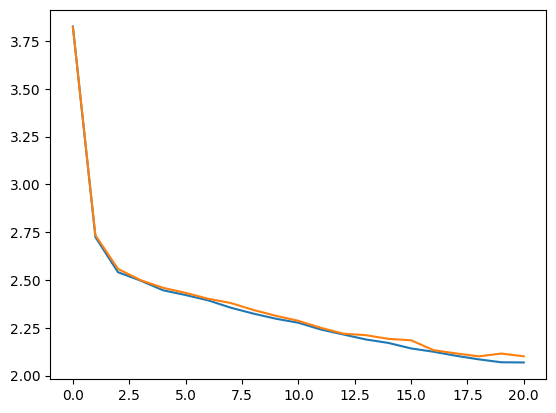

In [19]:
plt.plot([i['train'] for i in validation_losses.values()])
plt.plot([i['validation'] for i in validation_losses.values()])